<a href="https://www.kaggle.com/code/iamamir/data-analysis-of-new-york-city-taxi?scriptVersionId=161554418" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ny-taxi-data-2016/NY_Taxi_Data_2016.csv


#  Scenario
A taxi company in New York City (NYC) decided  wants to optimize the number of cabs waiting at JFK International Airport. The airport is well off the main Manhattan business district. As a result, it takes a very long time for taxis waiting there to be available for other areas. On the other hand, guests arriving at the airport usually cover longer and therefore more lucrative routes. So how many cabs should the cab operator provide at JFK?


![A service run by Via and Curb will give travelers in Manhattan the option of sharing a yellow cab with someone for a reduced fare.Credit...Joshua Bright for The New York Times](https://static01.nyt.com/images/2017/06/07/nyregion/07TAXI1/07TAXI1-superJumbo.jpg?quality=75&auto=webp)
Image taken from: https://static01.nyt.com/images/2017/06/07/nyregion/07TAXI1/07TAXI1-superJumbo.jpg?quality=75&auto=webp

In order to examine this questions, the company provides us with the data he collected from 2016 in the file NY_Taxi_Data_2016.csv


The following tasks have to be solved:
* What is the overall percentage of taxis booked from the airport (JFK)? This evaluation is therefore represented by the following formula:
# $Share_{JFK} = \frac{Trips_{JFK}}{Trips_{Overall}}$
* Where are taxis taken in New York? 
* What is the percentage of taxis booked from the airport per day of the week? On which day of the week is the highest proportion and when is the lowest?
# $Share_{Weekdays,JFK} = \frac{Trips_{Weekdays,JFK}}{Trips_{Weekdays,Overall}}$
* How much a day of the week contributes to the total number of trips? This should be done for the trips from the airport as well as for the entire set in order to be able to identify any differences.
# $Share_{Weekdays,Overall} = \frac{Trips_{Weekdays,Overall}}{Trips_{All Days,Overall}}$
# $Share_{Weekdays,JFK} = \frac{Trips_{Weekdays,JFK}}{Trips_{All Days,JFK}}$
* The proportion of a time in the total number of journeys. This should be done for the trips from the airport as well as for the entire set in order to be able to identify any differences
# $Share_{Time,Overall} = \frac{Trips_{Time,Overall}}{Trips_{All Time,Overall}}$
# $Share_{Time,JFK} = \frac{Trips_{Time,JFK}}{Trips_{All Time,JFK}}$


The data is structured as follows:

| Column Number | Column Name         | Data Type             | Description                                                     |
|---------------|---------------------|-----------------------|-----------------------------------------------------------------|
| 0             | 'pickup_weekday'    | categorical (ordinal) | Day of the week on which the trip started (0=Monday, 6=Sunday)  |
| 1             | 'pickup_hour'       | categorical (ordinal) | Hour in which the pickup started                                |
| 2             | 'pickup_longitude'  | numeric (float)       | Longitude at which pickup started                               |
| 3             | 'pickup_latitude'   | numeric (float)       | Latitude where the pickup started                               |
| 4             | 'dropoff_longitude' | numeric (float)       | Longitude at which trip ended                                   |
| 5             | 'dropoff_latitude'  | numeric (float)       | Latitude at which the trip ended                                |
| 6             | 'passenger_count'   | categorical (ordinal) | Number of passengers in the car.                                |
| 7             | 'trip_distance'     | numeric (float)       | Traveled distance in miles                                      |
| 8             | 'fare_amount'       | numeric (float)       | Amount that the taximeter calculates based on time and distance |
| 9             | 'tip_amount'        | numeric (float)       | Tip given when paying by card (0.00 when paying in cash)        |
| 10            | 'tolls_amount'      | numeric (float)       | Tolls incurred                                                  |
| 11            | 'payment_type'      | categorical (nominal) | Type of payment (1=credit card, 2=cash, 3=no fee, 4=dispute)    |


In order to determine which trips depart from JFK Airport, you are given the following coordinates:

| Variable     | Value    | Description                               |
|--------------|----------|-------------------------------------------|
| jfk_max_lat  | 40.66018 | Maximum pickup latitude of airport rides  |
| jfk_min_lat  | 40.62666 | Minimum pickup latitude of airport rides  |
| jfk_max_long | -73.76599| Maximum pickup longitude of airport rides |
| jfk_min_long | -73.80822| Minimum pickup longitude of airport rides |

By the way, the coordinates of New York City are something like this:

| Variable     | Value    | Description                                |
|--------------|----------|--------------------------------------------|
| nyc_max_lat  | 40.9176  | Maximum pickup latitude of  New York City  |
| nyc_min_lat  | 40.5774  | Minimum pickup latitude of  New York City  |
| nyc_max_long |-73.7004  | Maximum pickup longitude of  New York City |
| nyc_min_long | -74.15   | Minimum pickup longitude of  New York City |

# **1) Data Gathering and Cleaning**

In [2]:
# Import required libraries: pandas and numpy
import pandas as pd
import numpy as np

##### Remarks ####
# method pd.read_csv offers dtype parameter by which data taype to each column can be manually assigned.
# This is required to significantly reduce the RAM required for storing numbers.or example, by default
# whole numbers are read as int64, i.e. each number requires 64 bits in memory. The larger this value,
# the larger whole numbers can be stored. For floating point numbers, the precision with which they are stored increases.
# However, our data is in an area that does not require such a large memory size. If the numbers are read in as int32,
# for example, only half the RAM is required by the DataFrame.With the following dictionary you can read in the data record with little memory:
# read and check the data
col_dtypes = {'pickup_weekday': 'int16', 
              'pickup_hour': 'int16', 
              'pickup_longitude': 'float32', 
              'pickup_latitude': 'float32', 
              'dropoff_longitude': 'float32', 
              'dropoff_latitude': 'float32', 
              'passenger_count': 'int16', 
              'trip_distance': 'float32', 
              'fare_amount': 'float32', 
              'tip_amount': 'float32', 
              'tolls_amount': 'float32', 
              'payment_type': 'int16'}
# Read the data
df = pd.read_csv('/kaggle/input/ny-taxi-data-2016/NY_Taxi_Data_2016.csv', dtype=col_dtypes)
display(df.head())

# Check the data types
display(df.dtypes)

,pickup_weekday,pickup_hour,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,payment_type
0,3,19,-73.789970,40.646660,-74.005051,40.748081,1,18.610001,52.0,10.00,5.54,1
1,5,3,-73.986237,40.746513,-73.996796,40.742504,1,0.990000,5.0,1.00,0.00,1
2,4,20,-73.874634,40.773960,-73.959923,40.762802,3,9.250000,26.5,8.34,5.54,1
3,5,2,-73.952477,40.772064,-73.949371,40.675156,1,9.200000,28.0,0.00,0.00,2
4,4,21,-73.988281,40.764488,-73.996513,40.753239,1,0.900000,5.0,1.26,0.00,1


pickup_weekday         int16
pickup_hour            int16
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count        int16
trip_distance        float32
fare_amount          float32
tip_amount           float32
tolls_amount         float32
payment_type           int16
dtype: object

In [3]:
# Scaling categorial data
categorial_col = ['pickup_weekday','pickup_hour','passenger_count','payment_type']
numerical_cols = [col for col in df.columns.values.tolist() if col not in categorial_col ]
df.loc[:,categorial_col] = df.loc[:,categorial_col].astype('category')

# Check the data type again   
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   pickup_weekday     300000 non-null  category
 1   pickup_hour        300000 non-null  category
 2   pickup_longitude   300000 non-null  float32 
 3   pickup_latitude    300000 non-null  float32 
 4   dropoff_longitude  300000 non-null  float32 
 5   dropoff_latitude   300000 non-null  float32 
 6   passenger_count    300000 non-null  category
 7   trip_distance      300000 non-null  float32 
 8   fare_amount        300000 non-null  float32 
 9   tip_amount         300000 non-null  float32 
 10  tolls_amount       300000 non-null  float32 
 11  payment_type       300000 non-null  category
dtypes: category(4), float32(8)
memory usage: 10.3 MB


In [4]:
# Any missing values?
print(df.isna().sum())

pickup_weekday       0
pickup_hour          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
trip_distance        0
fare_amount          0
tip_amount           0
tolls_amount         0
payment_type         0
dtype: int64


In [5]:
# Check for obviously wrong and extreme values of GPS data
display(df.describe())

# GPS column name
GPS_data = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']


# Define new DataFrame for comparing the results
df_cleaned = df

# Delete extreme values of GPS data for any values equal to zero and less than -100,
# regrading to table of descreptive statistics 
for col in GPS_data:    
    mask_gps = (df_cleaned.loc[:,col] == 0) | (df_cleaned.loc[:,col] < -100)
    print(f'Number of exterem values for {col} is:', mask_gps.sum())    
    df_cleaned = df_cleaned.drop(df_cleaned.index[mask_gps])

# Delete trips with zero distance
mask_dist = df_cleaned.loc[:,'trip_distance'] == 0
print(f'Number of exterem vlaues for trip distance is', mask_dist.sum())
df_cleaned = df_cleaned.drop(df_cleaned.index[mask_dist])




print('\n')
display(f'Size of initial data frame:', df.shape)
print('--------------------------------------------')
display(f'Size of cleaned data frame:', df_cleaned.shape)

# Check the descriptive statistics of cleaned data
display(df_cleaned.describe())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,fare_amount,tip_amount,tolls_amount
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,-72.790047,40.098637,-72.857468,40.136742,2.847915,12.382164,1.770859,0.283985
std,9.285509,5.115375,9.019335,4.968787,3.532295,11.528932,2.514726,1.369848
min,-130.829086,0.000000,-83.158806,0.000000,0.000000,-75.000000,-0.990000,0.000000
25%,-73.991676,40.736401,-73.991287,40.734573,1.000000,6.500000,0.000000,0.000000
50%,-73.981552,40.753294,-73.979713,40.753658,1.660000,9.000000,1.350000,0.000000
75%,-73.966751,40.767811,-73.962318,40.769326,3.040000,14.000000,2.350000,0.000000
max,0.000000,48.857597,0.000000,42.186756,179.300003,2020.000000,299.799988,101.059998


Number of exterem values for pickup_longitude is: 4804
Number of exterem values for pickup_latitude is: 0
Number of exterem values for dropoff_longitude is: 420
Number of exterem values for dropoff_latitude is: 0
Number of exterem vlaues for trip distance is 1169




'Size of initial data frame:'

(300000, 12)

--------------------------------------------


'Size of cleaned data frame:'

(293607, 12)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,fare_amount,tip_amount,tolls_amount
count,293607.000000,293607.000000,293607.000000,293607.000000,293607.000000,293607.000000,293607.000000,293607.000000
mean,-73.974289,40.751186,-73.974083,40.751862,2.865220,12.332421,1.766166,0.282641
std,0.047202,0.045325,0.041882,0.037871,3.536179,10.649729,2.460342,1.363648
min,-83.158806,27.844738,-83.158806,32.181141,0.010000,-75.000000,0.000000,0.000000
25%,-73.991844,40.737625,-73.991432,40.735939,1.000000,6.500000,0.000000,0.000000
50%,-73.981857,40.754017,-73.980103,40.754330,1.680000,9.000000,1.350000,0.000000
75%,-73.967918,40.768150,-73.963531,40.769691,3.070000,14.000000,2.350000,0.000000
max,-67.496796,48.857597,-70.815041,42.186756,179.300003,1000.000000,299.799988,101.059998


# **2) Data Selection**

Now we would select the data related to the pickup coordinates of the airport and store them in a new DataFrame.

In [6]:
# Define desired coorditaes of JFK airport
jfk_max_lat = 40.66018 # define maximal latitude
jfk_min_lat = 40.62666 # define minimal latitude
jfk_max_long = -73.76599 # define maximal longitude
jfk_min_long = -73.80822 # define minimal longitude

# Create masks and select the data mask for values with the correct latitude
mask_lat_jfk = (df.loc[:, 'pickup_latitude'] >= jfk_min_lat) & \
                (df.loc[:, 'pickup_latitude'] <= jfk_max_lat) 
# Mask for values with the correct longitude
mask_long_jfk = (df.loc[:, 'pickup_longitude'] >= jfk_min_long) & \
                (df.loc[:, 'pickup_longitude'] <= jfk_max_long) 

# Combine both masks
mask_jfk_pickup = (mask_lat_jfk & mask_long_jfk) 

# Print the number of plausible gps dataponts are in the airport area 
print('\n')
print(f'Number of datapoints in airport area (plausible datapoint range:', mask_jfk_pickup.sum()) 
print('\n')

# Define new DataFrame for airport data
df_jfk = df_cleaned.loc[mask_jfk_pickup, :] 
df_jfk.describe()



Number of datapoints in airport area (plausible datapoint range: 5790




,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,fare_amount,tip_amount,tolls_amount
count,5674.000000,5674.000000,5674.000000,5674.000000,5674.000000,5674.000000,5674.000000,5674.000000
mean,-73.784187,40.645405,-73.941925,40.732212,16.138691,46.140038,5.881472,2.756036
std,0.005531,0.002085,0.076208,0.051286,5.290612,14.480885,5.762765,2.972831
min,-73.807480,40.639713,-74.730721,40.560028,0.010000,-52.000000,0.000000,0.000000
25%,-73.789536,40.644604,-73.986464,40.702512,13.802500,41.500000,0.000000,0.000000
50%,-73.782475,40.645111,-73.973145,40.744158,17.600000,52.000000,5.450000,0.000000
75%,-73.781303,40.646609,-73.927147,40.761844,19.000000,52.000000,11.650000,5.540000
max,-73.774986,40.659447,-73.124123,41.094330,70.290001,264.500000,50.000000,32.799999


# **3) The Ratio of Airport Taxis**

The question here is: What is the overall percentage of taxis booked from the airport?- as described above

In [7]:
# What is the ratio of trips starting from JFK?
print(f'Ratio of trips starting from JFK is {round(df_jfk.shape[0] / df.shape[0],3)*100} %')

Ratio of trips starting from JFK is 1.9 %


In [8]:
df_jfk.shape

(5674, 12)

The taxi company now knows how large the proportion of its fleet is that is tied to the airport business.

# **4) Visualize Pick Up Points**

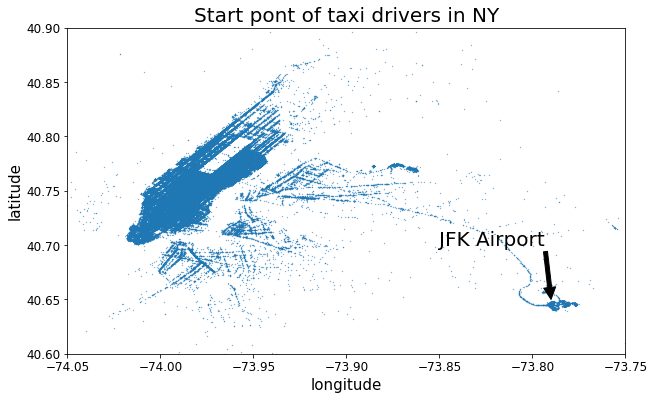

In [9]:
# Import matplotlib and magic command
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Initilize the plot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(x="pickup_longitude", y="pickup_latitude", data=df,
                 scatter=True, fit_reg=False, scatter_kws={"s": 0.1})

# Add annotation
ax.annotate(text='JFK Airport',
            xy=[-73.79,40.65],
            xytext=[-73.85,40.7],
            arrowprops=dict(facecolor='black'),fontsize=20);

ax.set_title('Start pont of taxi drivers in NY',fontsize=20);
ax.set_xlabel('longitude',fontsize=15)
ax.set_ylabel('latitude', fontsize=15)
ax.set(xlim=[-74.05, -73.75],
       ylim=[40.60, 40.90]);  # adjust axis limits
#set tick labels font size for both axes
plt.tick_params(axis='both', which='major', labelsize=12)
sns.set_style("darkgrid")



The taxi operator now knows where his taxis start their journeys.

# **5) Ratio of Airport Taxis Per Day**

The question here is: What is the percentage of taxis booked from the airport per day of the week?- as described above

,Weekdays,Trips Ratio %
0,Mo,2.6
1,Tu,2.0
2,Wed,1.7
3,Thu,1.8
4,Fri,1.8
5,Sat,1.4
6,Sun,2.0


Mean proportion of JFK trips per day is 1.9 %


[Text(0, 0, '2.6'),
 Text(0, 0, '2'),
 Text(0, 0, '1.7'),
 Text(0, 0, '1.8'),
 Text(0, 0, '1.8'),
 Text(0, 0, '1.4'),
 Text(0, 0, '2')]

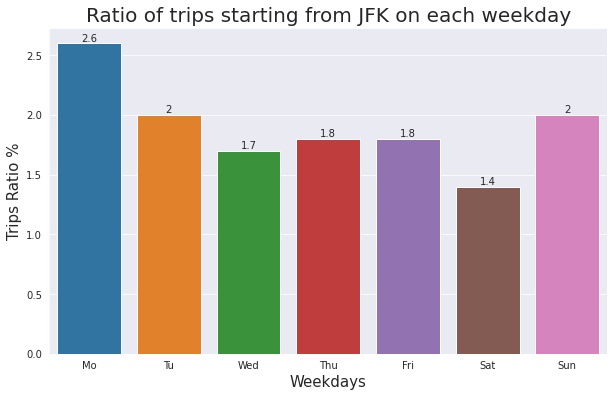

In [10]:
# What is the ratio of trips starting from JFK on each weekday?

#  Define weekdays 
days = {0:'Mo', 1:'Tu', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

# Count trips starting from JFK
counts_days_jfk = pd.crosstab(index=df_jfk['pickup_weekday'],
                          columns='count')

# Count trips starting from JFK
counts_days_all = pd.crosstab(index=df['pickup_weekday'],
                          columns='count')

df_rt_jfk = pd.DataFrame()
df_rt_jfk_all = pd.DataFrame()

week_days = list(days.values())
df_rt_jfk['Weekdays'] = week_days
df_rt_jfk['Trips Ratio %'] = round(counts_days_jfk / counts_days_all,3)*100
display(df_rt_jfk)

# Check whether the mean proportion of jfk-journeys per day is the same as the average proportion of jfk-journeys
print(f'Mean proportion of JFK trips per day is {round((counts_days_jfk / counts_days_all).mean()[0],3)*100} %')


fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df_rt_jfk, x = 'Weekdays', y ='Trips Ratio %' );
ax.set_title('Ratio of trips starting from JFK on each weekday',fontsize=20);
ax.set_xlabel('Weekdays',fontsize=15)
ax.set_ylabel('Trips Ratio %', fontsize=15)
ax.bar_label(ax.containers[0])


The taxi operator now knows how much of his fleet is tied up with airport business every day. As can be seen, the mean proportion of jfk-journeys per day, 1.9 %, is the same as the average proportion of jfk-journeys.

# **6) Ratio of Trips of Weekdays in Total and From the Airport**

The question here is: How much a day of the week contributes to the number of trips. This should be done for the trips from the airport as well as for the entire set in order to be able to identify any differences.

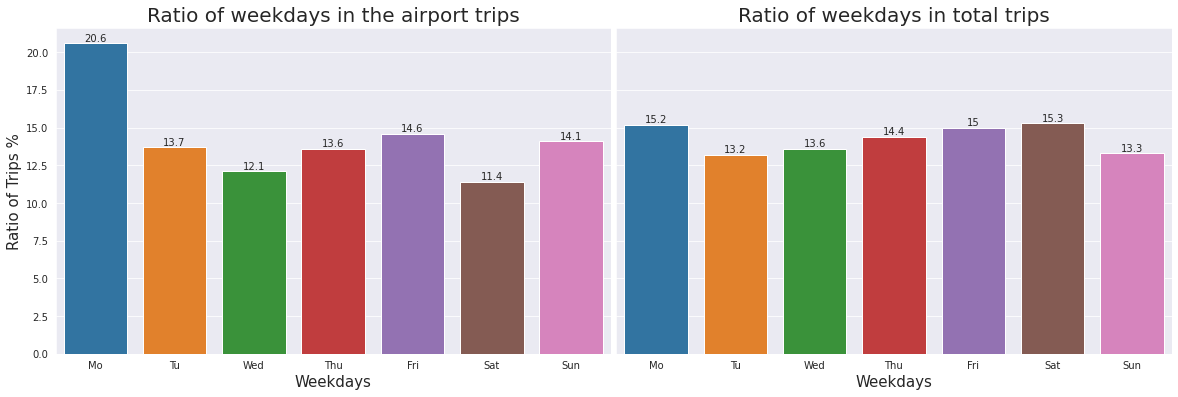

In [11]:
# Which weekdays have the most trips?

# Calculate the ratio to all airport trips
counts_days_jfk = pd.crosstab(index=df_jfk['pickup_weekday'],
                          columns='count')
counts_days_ratio_jfk = counts_days_jfk.loc[:, 'count'] / len(df_jfk)

# Calculate the ratio to all trips.
counts_days_all = pd.crosstab(index=df['pickup_weekday'],
                          columns='count')
counts_days_ratio_all = counts_days_all.loc[:, 'count'] / len(df)

# Define a data frame for better visialisation reults
df_rt_jfk['Weekdays'] = week_days
df_rt_jfk['Trips Ratio'] = round(counts_days_ratio_jfk,3)*100
df_rt_jfk_all['Weekdays'] = list(days.values())
df_rt_jfk_all['Trips Ratio'] = round(counts_days_ratio_all,3)*100

# Visualisations
fig, axes = plt.subplots(1,2, sharey=True, figsize=(20,6))
axes[0].set_title('Ratio of weekdays in the airport trips', fontsize=20)
axes[1].set_title('Ratio of weekdays in total trips', fontsize=20)

sns.barplot(data=df_rt_jfk, x='Weekdays', y= 'Trips Ratio', ax =axes[0]);
sns.barplot(data=df_rt_jfk_all, x='Weekdays', y= 'Trips Ratio', ax =axes[1]);

axes[0].set_ylabel('Ratio of Trips %', fontsize=15)
axes[1].set_ylabel('')
axes[0].set_xlabel('Weekdays', fontsize=15)
axes[1].set_xlabel('Weekdays', fontsize=15)
axes[0].bar_label(axes[0].containers[0]);
axes[1].bar_label(axes[1].containers[0]);
plt.subplots_adjust(wspace=0.01)

Now you have a good overview of which days the taxi traffic from the airport differs compared to all trips.

# **7) Ratio of Times in Total and From The Airport**

The question here is: what proportion a time has in the number of trips. This should be done for the trips from the airport as well as for the entire set in order to be able to identify any differences.

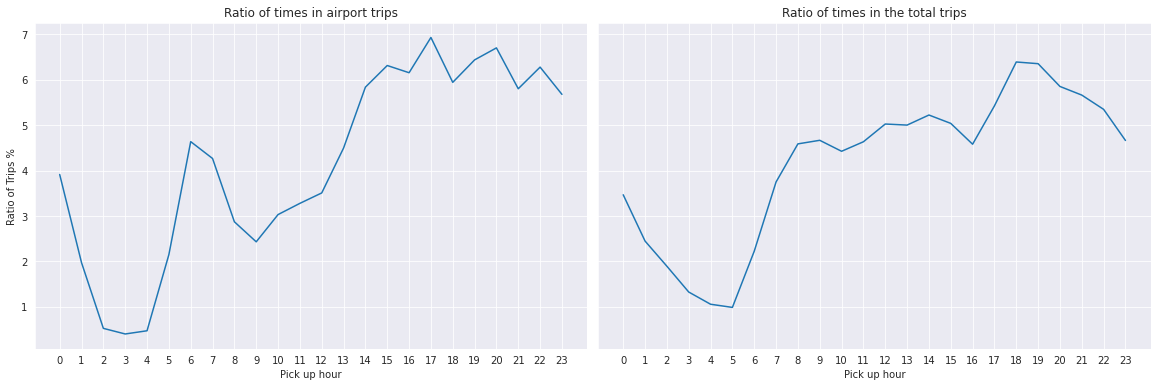

In [12]:
# Which times have the most trips?

# Determine the pick up hour ratio
count_hours_jfk = pd.crosstab(index=df_jfk['pickup_hour'],columns='count')
counts_hours_ratio_jfk = count_hours_jfk.loc[:,'count'] / len(df_jfk)*100

count_hours_all = pd.crosstab(index=df['pickup_hour'],columns='count')
counts_hours_ratio_all = count_hours_all.loc[:,'count'] / len(df)*100


# Visualisations
fig, axes = plt.subplots(1,2, sharey=True, figsize=(20,6))
sns.set_style("darkgrid")
sns.lineplot(data=counts_hours_ratio_jfk, ax =axes[0]);
sns.lineplot(data=counts_hours_ratio_all, ax =axes[1]);
axes[0].set_title('Ratio of times in airport trips')
axes[1].set_title('Ratio of times in the total trips')
axes[0].set_xlabel('Pick up hour')
axes[1].set_xlabel('Pick up hour')
axes[0].set_xticks(np.arange(min(df['pickup_hour']), max(df['pickup_hour'])+1, 1.0))
axes[1].set_xticks(np.arange(min(df['pickup_hour']), max(df['pickup_hour'])+1, 1.0))


sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
axes[0].set_ylabel('Ratio of Trips %')
plt.subplots_adjust(wspace=0.02)

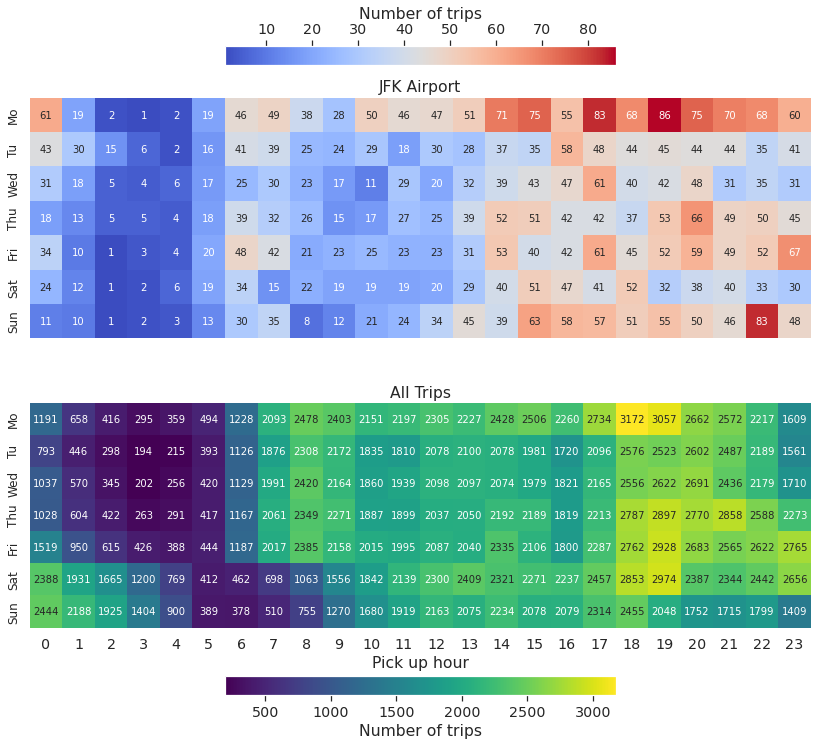

In [13]:
# Taxi Pickup frequency at different tome of the day
day_time_count_jfk = pd.crosstab(df_jfk['pickup_weekday'],df_jfk['pickup_hour'])
fig, ax = plt.subplots(nrows=2,figsize=(14,13),sharex=True)
sns.heatmap(day_time_count_jfk,ax=ax[0],annot_kws={'size': 10},
            cmap="coolwarm",cbar=False,annot=True);
fig.colorbar(ax[0].collections[0], label='Number of trips',
             ax=ax[0],location="top", pad=0.1,
             orientation='horizontal',shrink=0.5);
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('JFK Airport');
ax[0].set_yticklabels(week_days,fontsize=12);

day_time_count_all = pd.crosstab(df['pickup_weekday'],df['pickup_hour'])
sns.heatmap(day_time_count_all,ax=ax[1],cmap="viridis",cbar=False,
            annot=True,annot_kws={'size': 10},fmt=".4g"); # fmt=".4g": four significant figures
fig.colorbar(ax[1].collections[0], label='Number of trips',
             ax=ax[1],location="bottom", pad=0.15,
             orientation='horizontal',shrink=0.5);
ax[1].set_xlabel('Pick up hour')
ax[1].set_yticklabels(week_days,fontsize=12);
ax[1].set_ylabel('');
ax[1].set_title('All Trips');

Now we have a good overview of the times at which taxi traffic from the airport differs compared to all trips.

In [14]:
# Correlation Between Attributes
corr = df_jfk.corr()
corr.style.background_gradient(cmap='coolwarm')
# Colormap: Most negative correlations (dark-blue) to most positive correlation (dark red)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance,fare_amount,tip_amount,tolls_amount
pickup_longitude,1.000000,-0.131896,0.051018,-0.048713,0.007130,-0.043331,0.014206,-0.073745
pickup_latitude,-0.131896,1.000000,0.013082,0.010968,-0.063964,-0.021432,-0.039112,0.033386
dropoff_longitude,0.051018,0.013082,1.000000,-0.188921,-0.691690,-0.609008,-0.311945,-0.438690
dropoff_latitude,-0.048713,0.010968,-0.188921,1.000000,0.483516,0.446642,0.170801,0.533443
trip_distance,0.007130,-0.063964,-0.691690,0.483516,1.000000,0.869953,0.361710,0.518341
fare_amount,-0.043331,-0.021432,-0.609008,0.446642,0.869953,1.000000,0.379100,0.497682
tip_amount,0.014206,-0.039112,-0.311945,0.170801,0.361710,0.379100,1.000000,0.239565
tolls_amount,-0.073745,0.033386,-0.438690,0.533443,0.518341,0.497682,0.239565,1.000000



As can be seen, attributes like 'fare amount', 'tip amount', 'trip distance', and 'fare amount' are positively correlated to each other.

# **8) Remarks**

The main question of this project is: So how many cabs should the cab operator provide at JFK Airport depending on the day of the week and the time? When should the taxi company have more and when fewer taxis available at the airport?

* Taxi company now knows around 2% of its fleet were booked from JFK airport.
* Pick up maps also confirms that, besides the NYC, JFK airport is the busiet pick-up location.
* It can be seen that, from the section 5, monday, sunday and tuesday are three busiest days respectievly. 
*  Monday, friday and saturday are three wekkdays in which most trips occured. Diagrams in part 6 indicate that
 most of the airport trips are on monday with 20.6 % of all trips on a week. 
* As it is expected, the number of people who needs taxi increases after early morning (5:00 am), both
in total trips and in the airport. The demand of taxi is considerably high between 15:00 and 21:00. Considering non airport's pick ups, it makes sense as this is the time when people return from their offices. It could be the case also for some airports employess who wants to come back home at the evening.
* All in all, from the short analysis above, it can be suggested that Mondays from 5:00 am and 00:00 
is the time interval which taxi company can be considered as high demand of taxi at the JFK airport.
* To be a bit more precise in airport-related data, Heatmaps in section 7 confirm that
On Mondays from 14:00 till 01:00 more people (around 80) needed
caps compared to other days. Sunday at 22:00 is another time interval with a maximum demand of caps
which might be related to landing one or several flights with more than the average number of passengers.
This time interval should be interesting for the taxi company as well.
* Every day (Weekdays and weekend as well) btween 02:00 till 05:00 is the minimum demand of caps
at the airport. This time interval needs to be considered for the taxi company.